## Number of bug reports submitted

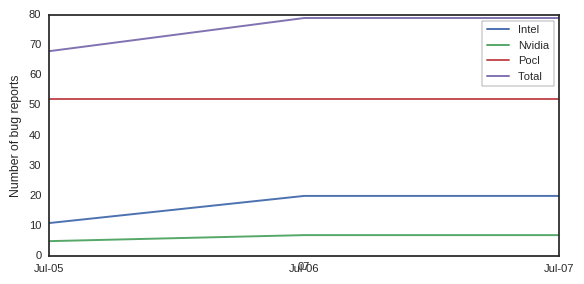

In [49]:
import re
import dateutil.parser
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from labm8 import fs
from labm8 import viz
from matplotlib import pyplot as plt

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])
matplotlib.rcParams['figure.dpi'] = 120

def lc(path):
    with open(path) as infile:
        return len(infile.readlines())
    
def lc_by_vendor(path):
    counts = dict()
    with open(path) as infile:
        for line in infile:
            m = re.search("bug-report-([^-]+)-", line)
            vendor = m.group(1).capitalize()
            counts[vendor] = counts.get(vendor, 0) + 1
    counts["Total"] = sum(counts.values())
    return counts

dates, data = [], []
for log in fs.ls("../data/bug-reports/.logs", abspaths=True):
    date = dateutil.parser.parse(fs.basename(log).replace(".txt", ""))
    dates.append(date)
    data.append(lc_by_vendor(log))

ax = pd.DataFrame(data, index=dates).plot()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.get_legend().draw_frame(True)
plt.ylabel("Number of bug reports")
viz.finalise(figsize=(6, 3))

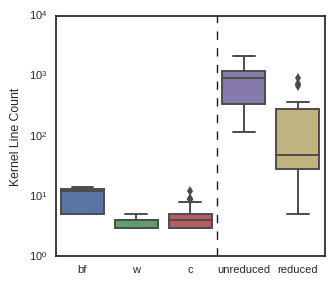

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/kernel-sizes.pdf
[master 7f9e386] auto: build/img/kernel-sizes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 3.03 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   31765dd..7f9e386  master -> master


In [59]:
import db as db
import sqlalchemy as sql

from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

TABLES = [
    (coCLgenResult, "Compiler errors"),
    (cl_launcherCLgenResult, "Miscompilation"),
]

data = []
with Session(commit=False) as s:
    for table, name in TABLES:
        q = s.query(table).filter(table.submitted)
        data += [{
            "Bug type": classification_to_paper(result.classification), 
            "Kernel Line Count": len(result.program.src.strip().split('\n'))
        } for result in q]

for file in fs.ls(fs.path("~/src/project_b/data/clreduce"), recursive=True, abspaths=True):
    if file.endswith(".red.cl"):
        data += [{"Bug type": "reduced", "Kernel Line Count": lc(file)}]
    if file.endswith(".red.cl.orig"):
        data += [{"Bug type": "unreduced", "Kernel Line Count": lc(file)}]

table = pd.DataFrame(data)

def plot(table, *args, **kwargs):
    ax = sns.boxplot(x="Bug type", y="Kernel Line Count", data=table)
    
    # yaxis
    ax.set_yscale("log")
    
    # x axis
    plt.xlabel("")
    plt.axvline(x=plt.xlim()[1] - 2, color="k", lw=1, linestyle="--")
    
    viz.finalise(*args, **kwargs)

plot(table, figsize=(3.5, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase && mkdir -pv build/img
plot(table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(3.5, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

In [54]:
table.groupby("Bug type").median()

,Kernel Line Count
Bug type,
bf,12
c,4
reduced,49
unreduced,906
w,4


In [ ]:
data = []
for file in fs.ls(fs.path("~/src/project_b/data/clreduce"), recursive=True, abspaths=True):
    if file.endswith(".red.cl"):
        data += [{"Bug type": "CLSmith", "Kernel Line Count": lc(file)}]

#ax = sns.boxplot(x="Bug")